<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Se√±ales
# Semana 4:
#### Nicolas Pereyra
---
## Consigna:

### TS4: Simulaci√≥n de un ADC (cuantizaci√≥n y alias) parte 2/2

En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantizaci√≥n de un ADC de B bits en un rango de  ¬±VF Volts. Ahora vamos a completar la simulaci√≥n del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simular√° el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los par√°metros a ajustar de la senoidal:

- Frecuencia $f_{o}$ arbitraria, por ejemplo $f_{0}=\frac{f_{S}}{N}=\Delta f$
- Energ√≠a normalizada, es decir energ√≠a (o varianza) unitaria

Con respecto a los par√°metros de la secuencia de ruido, diremos que:

+ Ser√° de car√°cter aditivo, es decir la se√±al que entra al ADC ser√° $s_{R}=s+n$. Siendo $n$ la secuencia que simula la interferencia, y $s$ la senoidal descrita anteriormente.
+ La potencia del ruido ser√° $P_{n}=k_{n}.P_{q}$ siendo el factor $k$ una escala para la potencia del ruido de cuantizaci√≥n $P_{q}=\frac{q¬≤}{12}$.
+ Finalmente, $n$ ser√° incorrelado y Gaussiano.

El ADC que deseamos simular trabajar√° a una frecuencia de muestreo $f_{S}=1000$ Hz y tendr√° un rango anal√≥gico de $¬±VF=2$ Volts.

Se pide:

    a) Generar el siguiente resultado producto de la experimentaci√≥n. B = 4 bits, kn=1.
    b) Analizar para una de las siguientes configuraciones B = Ã£{4, 8 y 16} bits, kn={1/10,1,10}. Discutir los resultados respecto a lo obtenido en a).

Bonus:

    üíé Encontrar la relaci√≥n entre la cantidad de B bits del ADC y el SNR de la se√±al digitalizada. (Ver Holton. DSP Principles and App. 6.7 ADC Quantization pag. 387 )
    ü§Ø Simular el efecto del aliasing junto con el muestreo.

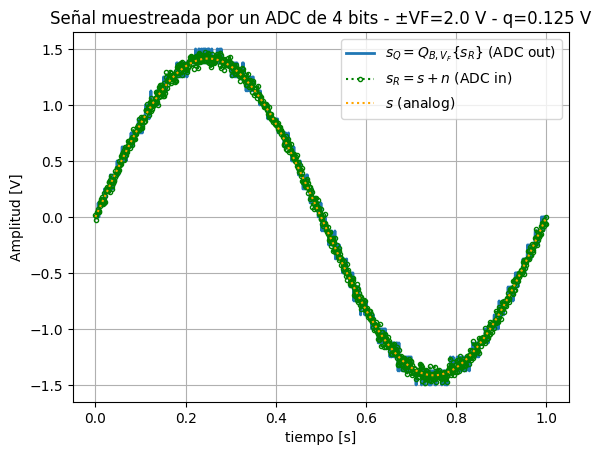

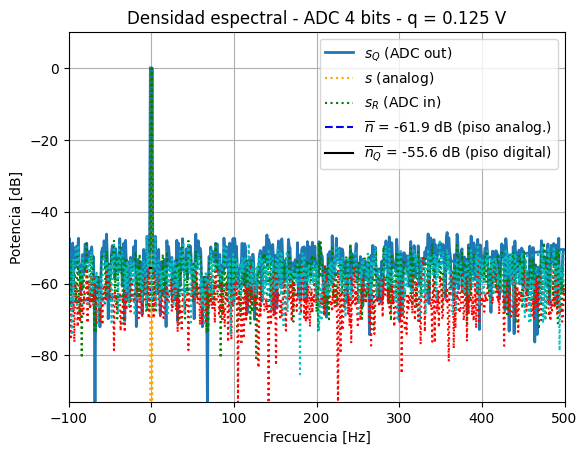

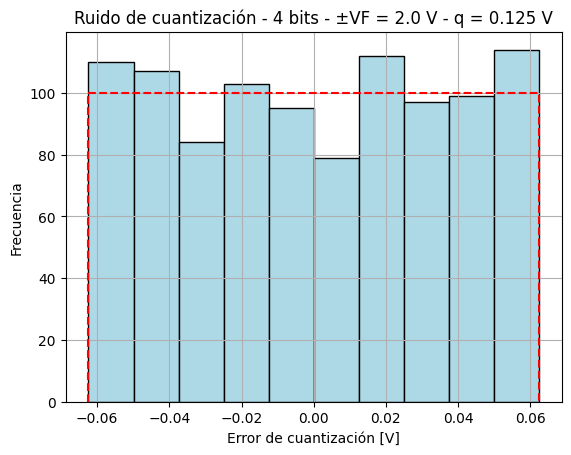

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# --- Configuraci√≥n de la simulaci√≥n ---
fs = 1000.0          # Frecuencia de muestreo [Hz]
N = 1000             # Cantidad de muestras
over_sampling = 4    # Oversampling para se√±al anal√≥gica
N_os = N * over_sampling

B = 4                # Cantidad de bits del ADC
Vf = 2               # Rango total del ADC ¬±Vf
q = Vf / (2**B)      # Paso de cuantizaci√≥n
kn = 1               # Factor de potencia del ruido (k_n)

# Tiempo continuo y muestreado
ts_os = 1 / (fs * over_sampling)
tt_os = np.arange(0, N_os) * ts_os
ts = 1 / fs
tt = np.arange(0, N) * ts

# Frecuencia de la se√±al
f0 = fs / N*1  # f0 = Œîf
omega0 = 2 * np.pi * f0

# --- Se√±al anal√≥gica (energ√≠a unitaria) ---
analog_sig = np.sqrt(2) * np.sin(omega0 * tt_os)  # Varianza 1

# --- Se√±al muestreada ---
s = np.sqrt(2) * np.sin(omega0 * tt)  # Varianza unitaria tambi√©n

# --- Ruido gaussiano aditivo ---
Pq = q**2 / 12  # Potencia del ruido de cuantizaci√≥n
Pn = kn * Pq    # Potencia del ruido
n = np.random.normal(0, np.sqrt(Pn), size=N)

# Se√±al contaminada con ruido
sr = s + n

# --- Cuantizaci√≥n (funci√≥n de cuantizaci√≥n uniforme) ---
srq = q * np.floor(sr / q + 0.5)

# --- Ruido de cuantizaci√≥n ---
nq = srq - sr

# --- FFTs ---
ff = np.fft.fftfreq(N, d=ts)
ft_Srq = np.fft.fft(srq) / N
ft_SR = np.fft.fft(sr) / N
ft_Nq = np.fft.fft(nq) / N

# FFT sobre muestreo
ff_os = np.fft.fftfreq(N_os, d=ts_os)
ft_As = np.fft.fft(analog_sig) / N_os

# FFT del ruido gaussiano puro
nNn = np.random.normal(0, np.sqrt(Pn), size=N_os)
ft_Nn = np.fft.fft(nNn) / N_os

# C√°lculo de potencias promedio
nNn_mean = np.mean(np.abs(ft_Nn)**2)
Nnq_mean = np.mean(np.abs(ft_Nq)**2)

# --- Gr√°fico temporal ---
plt.figure(1)
plt.plot(tt, srq, lw=2, label='$s_Q = Q_{B,V_F}\\{s_R\\}$ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$s_R = s + n$ (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$s$ (analog)')
plt.title(f'Se√±al muestreada por un ADC de {B} bits - ¬±VF={Vf:.1f} V - q={q:.3f} V')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.grid(True)

# --- Gr√°fico espectral ---
plt.figure(2)
bfrec = (ff >= -100) & (ff <= fs/2)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), lw=2, label='$s_Q$ (ADC out)')
plt.plot(ff_os[ff_os <= fs/2], 10 * np.log10(2 * np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$s$ (analog)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), ':g', label='$s_R$ (ADC in)')
plt.plot(ff_os[ff_os <= fs/2], 10 * np.log10(2 * np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), ':c')

plt.plot([ff[bfrec][0], ff[bfrec][-1]], [10*np.log10(2*nNn_mean)]*2, '--b', label=f'$\overline{{n}}$ = {10*np.log10(2*nNn_mean):.1f} dB (piso analog.)')
plt.plot([ff[bfrec][0], ff[bfrec][-1]], [10*np.log10(2*Nnq_mean)]*2, 'black', label=f'$\overline{{n_Q}}$ = {10*np.log10(2*Nnq_mean):.1f} dB (piso digital)')
plt.title(f'Densidad espectral - ADC {B} bits - q = {q:.3f} V')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim([-100, fs / 2])
plt.legend()
plt.grid(True)
plt.ylim((1.5*np.min(10*np.log10(2*np.array([Nnq_mean, nNn_mean]))), 10))

# --- Histograma del ruido de cuantizaci√≥n ---
plt.figure(3)
bins = 10
plt.hist(nq, bins=bins, color='lightblue', edgecolor='black')
plt.plot([-q/2, -q/2, q/2, q/2], [0, N/bins, N/bins, 0], '--r')
plt.title(f'Ruido de cuantizaci√≥n - {B} bits - ¬±VF = {Vf:.1f} V - q = {q:.3f} V')
plt.xlabel('Error de cuantizaci√≥n [V]')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()

üîç Bonus: Relaci√≥n entre SNR y n√∫mero de bits

Para una cuantizaci√≥n uniforme ideal:
SNRdB=6.02‚ãÖB+1.76
SNRdB‚Äã=6.02‚ãÖB+1.76

Puedes verificar esta f√≥rmula agregando un c√°lculo emp√≠rico del SNR para cada configuraci√≥n si lo deseas.

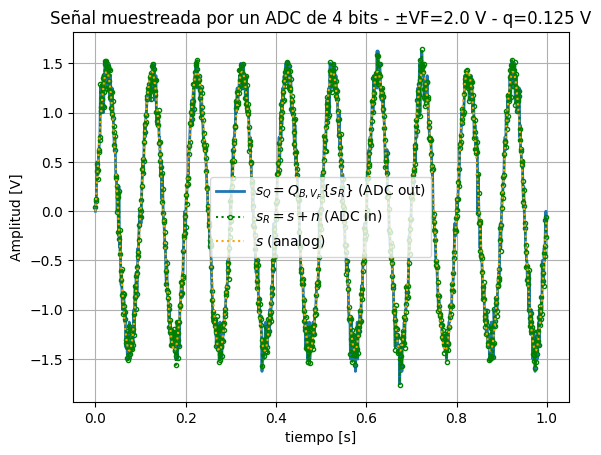

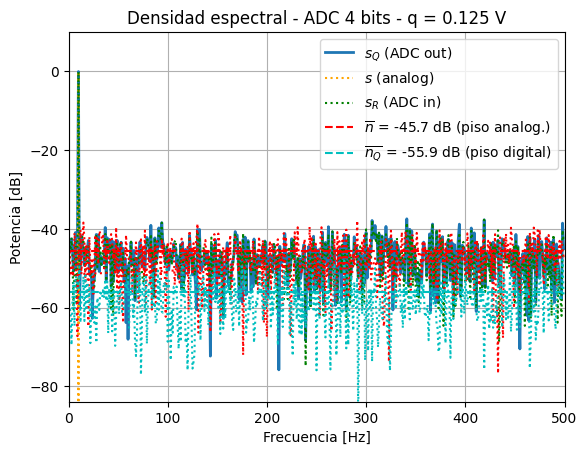

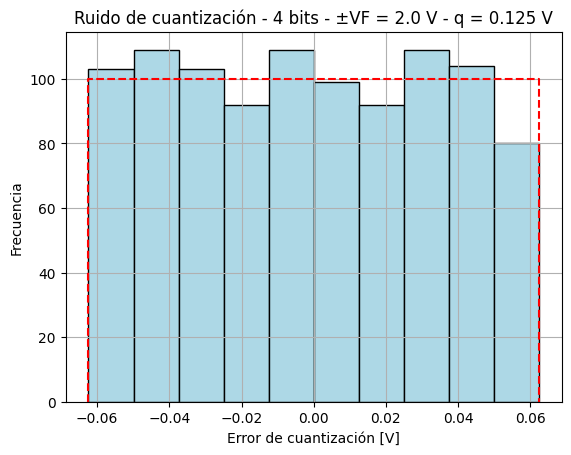

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Datos generales de la simulaci√≥n
fs = 1000.0 # frecuencia de muestreo (Hz)
N = 1000   # cantidad de muestras

# cantidad de veces m√°s densa que se supone la grilla temporal para tiempo "continuo"
over_sampling = 1
N_os = N*over_sampling

# Datos del ADC
B = 4 # bits
Vf = 2 # Volts
q = Vf/2**B # Volts

# datos del ruido
kn = 10

# Porencia de ruido
Pq = q**2 / 12  # Ruido de cuantizaci√≥n
Pn = kn * Pq    # Ruido analogico

# --- Ruido gaussiano aditivo ---
n = np.random.normal(0, np.sqrt(Pn), size=N)

# Tiempo continuo y muestreado
ts_os = 1 / (fs * over_sampling)
tt_os = np.arange(0, N_os) * ts_os
ts = 1 / fs
tt = np.arange(0, N) * ts

# Frecuencia de la se√±al
f0 = fs / N*10  # f0 = Œîf
omega0 = 2 * np.pi * f0

# --- Se√±al anal√≥gica (energ√≠a unitaria) ---
analog_sig = np.sqrt(2) * np.sin(omega0 * tt_os)  # Varianza 1

# --- Se√±al muestreada ---
s = np.sqrt(2) * np.sin(omega0 * tt)  # Varianza unitaria tambi√©n



# Se√±al contaminada con ruido
sr = s + n

# --- Cuantizaci√≥n (funci√≥n de cuantizaci√≥n uniforme) ---
srq = q * np.floor(sr / q + 0.5)

# --- Ruido de cuantizaci√≥n ---
nq = srq - sr

# --- FFTs ---
ff = np.fft.fftfreq(N, d=ts)
ft_Srq = np.fft.fft(srq) / N
ft_SR = np.fft.fft(sr) / N
ft_Nq = np.fft.fft(nq) / N

# FFT sobre muestreo
ff_os = np.fft.fftfreq(N_os, d=ts_os)
ft_As = np.fft.fft(analog_sig) / N_os

# FFT del ruido gaussiano puro
nNn = np.random.normal(0, np.sqrt(Pn), size=N_os)
ft_Nn = np.fft.fft(nNn) / N_os

# C√°lculo de potencias promedio
nNn_mean = np.mean(np.abs(ft_Nn)**2)
Nnq_mean = np.mean(np.abs(ft_Nq)**2)

# --- Gr√°fico temporal ---
plt.figure(1)
plt.plot(tt, srq, lw=2, label='$s_Q = Q_{B,V_F}\\{s_R\\}$ (ADC out)')
plt.plot(tt, sr, linestyle=':', color='green', marker='o', markersize=3, markerfacecolor='none', markeredgecolor='green', fillstyle='none', label='$s_R = s + n$ (ADC in)')
plt.plot(tt_os, analog_sig, color='orange', ls='dotted', label='$s$ (analog)')
plt.title(f'Se√±al muestreada por un ADC de {B} bits - ¬±VF={Vf:.1f} V - q={q:.3f} V')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.grid(True)

# --- Gr√°fico espectral ---
plt.figure(2)
bfrec = (ff >= 0) & (ff <= fs/2)
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Srq[bfrec])**2), lw=2, label='$s_Q$ (ADC out)')
plt.plot(ff_os[ff_os <= fs/2], 10 * np.log10(2 * np.abs(ft_As[ff_os <= fs/2])**2), color='orange', ls='dotted', label='$s$ (analog)')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), ':g', label='$s_R$ (ADC in)')
plt.plot(ff_os[ff_os <= fs/2], 10 * np.log10(2 * np.abs(ft_Nn[ff_os <= fs/2])**2), ':r')
plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), ':c')

plt.plot([ff[bfrec][0], ff[bfrec][-1]], [10*np.log10(2*nNn_mean)]*2, '--r', label=f'$\overline{{n}}$ = {10*np.log10(2*nNn_mean):.1f} dB (piso analog.)')
plt.plot([ff[bfrec][0], ff[bfrec][-1]], [10*np.log10(2*Nnq_mean)]*2, '--c', label=f'$\overline{{n_Q}}$ = {10*np.log10(2*Nnq_mean):.1f} dB (piso digital)')
plt.title(f'Densidad espectral - ADC {B} bits - q = {q:.3f} V')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim([0, fs / 2])
plt.legend()
plt.grid(True)
plt.ylim((1.5*np.min(10*np.log10(2*np.array([Nnq_mean, nNn_mean]))), 10))

# --- Histograma del ruido de cuantizaci√≥n ---
plt.figure(3)
bins = 10
plt.hist(nq, bins=bins, color='lightblue', edgecolor='black')
plt.plot([-q/2, -q/2, q/2, q/2], [0, N/bins, N/bins, 0], '--r')
plt.title(f'Ruido de cuantizaci√≥n - {B} bits - ¬±VF = {Vf:.1f} V - q = {q:.3f} V')
plt.xlabel('Error de cuantizaci√≥n [V]')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.show()
